In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch
import os


# Visualize

In [111]:
import matplotlib.pyplot as plt

def plot_side_by_side(image1, image2, image3, idx, save_path, titles=None):
    """
    Plots three images side by side.

    Args:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        image3 (np.ndarray): The third image.
        titles (list, optional): A list of titles for the images.

    Returns:
        None
    """

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[2].imshow(image3)
    axes[2].axis('off')
    
    if titles is not None:
        axes[0].set_title(titles[0])
        
        axes[1].set_title(titles[1])
        axes[2].set_title(titles[2])

    plt.tight_layout()
    
    if save_path is not None:
        filename = os.path.join(save_path, f"{idx}.jpg")
        plt.savefig(filename)


    plt.show()

In [112]:
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()


In [82]:
images_cw_base = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-Regular_integrated-False.pickle"
images_cw_rbf = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-Regular_integrated-True.pickle"
images_benign_base = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/Benign_Datasets/CW_benign_samples_5120_test_detector-type-Regular_integrated-True.pickle"

In [83]:
with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)

with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)

with open(images_benign_base, 'rb') as in_file:
    images_benign_base = pickle.load(in_file)

In [84]:
idx = 6

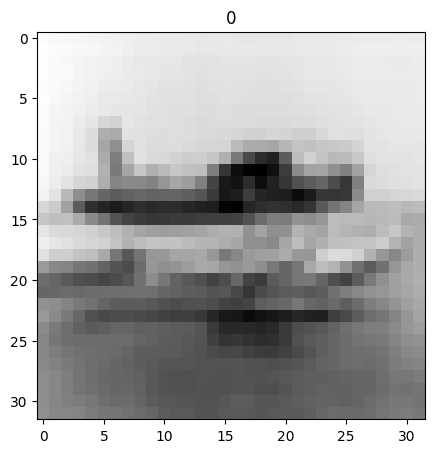

In [85]:
imshow(images_cw_base[0][idx], title=images_cw_base[1][idx].item())

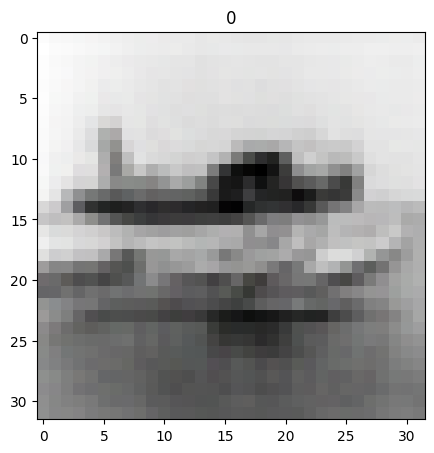

In [86]:

imshow(images_cw_rbf[0][idx], title=images_cw_rbf[1][idx].item())

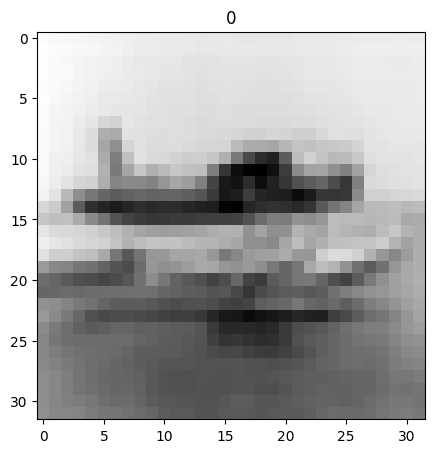

In [87]:
imshow(images_benign_base[0][idx], title=images_benign_base[1][idx].item())

# Analyze ReLUs

In [88]:

def load_data(path, label):
    features_matrix = torch.load(path)
    y = np.empty(features_matrix.shape[0])
    y.fill(label)
    return [features_matrix, y]


In [89]:
features_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/ReLUs/ReLUs_CW_test_adversarial_5120_detector-type-Regular_integrated-True.pth"

features = load_data(features_path, -1)

### Indeed, the features are RELUd

#### TODO 
Which version of resnet are they using?

What's the E-ball size below?

What are some standard eball sizes? CW BPDA paper

Report normalized l2 dissimilarity 

# Compute pixel-wise metrics


In [90]:
import torch.nn as nn

In [91]:
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [92]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign_base[0]))
print("Mean per-pixel difference between CW base and benign images is : ", l2_loss_base.item())

Mean per-pixel difference between CW base and benign images is :  8.63048990140669e-06


In [93]:
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign_base[0]))
print("Mean per-pixel difference between CW with RBF and benign images is : ", l2_loss_rbf.item())

Mean per-pixel difference between CW with RBF and benign images is :  1.627504389034584e-05


In [94]:
MSELoss = nn.MSELoss(reduction='none')
flatten = nn.Flatten()

In [95]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign_base[0]))
l2_loss_base = torch.max(l2_loss_base, dim=1)[0]
l2_loss_base = l2_loss_base.mean()
print("Mean max pixel differene between CW base and benign is : ", l2_loss_base.item())

Mean max pixel differene between CW base and benign is :  0.0004843912029173225


In [96]:
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign_base[0]))
l2_loss_rbf = torch.max(l2_loss_rbf, dim=1)[0]
l2_loss_rbf = l2_loss_rbf.mean()
print("Mean max pixel differene between CW RBF and benign is : ", l2_loss_rbf.item())

Mean max pixel differene between CW RBF and benign is :  0.0007357355207204819


In [ ]:
save_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_64532bf03dea249a46b41a734c5fc63b/Vis"

for idx in range(20):
    benign = images_benign_base[0][idx]
    cw_base = images_cw_base[0][idx]
    cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)


    cw_rbf = cw_rbf.swapaxes(0,1)
    cw_rbf = cw_rbf.swapaxes(1,2)

    plot_side_by_side(benign, cw_base, cw_rbf, idx, save_path)

In [114]:
cw_rbf.shape

torch.Size([32, 32, 3])